In [ ]:
import os
import random
import datetime
from pathlib import Path
import numpy as np
import torch

from config import DATA, TRAINING
from model.deepdemand import DeepDemand
from model.dataloader import load_gt, load_json, get_lsoa_vector
import model.utils as utils


def set_seeds(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)


def build_feature_bank():
    """
    Rebuild the same LSOA feature bank used in training.
    Honors optional PCA in TRAINING config (same as your trainer).
    """
    lsoa_json = load_json("data/node_features/lsoa21_features_normalized.json")
    node_to_lsoa = load_json("data/node_features/node_to_lsoa.json")

    lsoa_codes = sorted(lsoa_json.keys())
    rows = [get_lsoa_vector(lsoa_json[c]).cpu().numpy() for c in lsoa_codes]
    X = np.vstack(rows).astype(np.float32)

    feature_bank = {}

    if TRAINING.get("pca", False):
        # Recompute PCA (same seed + same data → same result); or load from .npz if you prefer.
        k = int(TRAINING.get("pca_components", 32))
        Xp, mean, comps = utils.pca_project(X, k)
        for i, code in enumerate(lsoa_codes):
            feature_bank[code] = torch.from_numpy(Xp[i])
    else:
        for i, code in enumerate(lsoa_codes):
            feature_bank[code] = torch.from_numpy(X[i])

    return feature_bank, node_to_lsoa


def load_model(checkpoint_path: str, device: torch.device) -> DeepDemand:
    feature_bank, node_to_lsoa = build_feature_bank()
    model = DeepDemand(feature_bank=feature_bank, node_to_lsoa=node_to_lsoa).to(device)

    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

    state = torch.load(checkpoint_path, map_location=device, weights_only=True)
    model.load_state_dict(state)
    model.eval()
    return model

@torch.no_grad()
def infer_on_edges(model: DeepDemand, edge_ids, edge_to_gt, scaler, device: torch.device):
    preds, gts = [], []
    for eid in edge_ids:
        gt = edge_to_gt[eid]
        y_hat = model(eid)
        if y_hat is None or y_hat.numel() == 0:
            continue

        # Move to CPU numpy
        y_hat = y_hat.detach().cpu().numpy().item()
        gt = float(gt)

        # Inverse scale (match your training/eval)
        if scaler:
            gt_arr = torch.tensor([gt], dtype=torch.float32).view(1, 1)
            y_arr = torch.tensor([y_hat], dtype=torch.float32).view(1, 1)
            gt = utils.inverse_transform_tensor(gt_arr, scaler).item() if hasattr(utils, "inverse_transform_tensor") else scaler.inverse_transform(gt_arr).item()
            y_hat = utils.inverse_transform_tensor(y_arr, scaler).item() if hasattr(utils, "inverse_transform_tensor") else scaler.inverse_transform(y_arr).item()

        gts.append(gt)
        preds.append(y_hat)

    return np.array(gts, dtype=np.float64), np.array(preds, dtype=np.float64)


In [3]:
checkpoint_path = "param/cv_1/best_stage_1_lr1e-03.pt"

set_seeds(TRAINING['seed'])
device = torch.device(TRAINING['device'])

# Load GT and split
edge_to_gt, scaler = load_gt()
all_edge_ids = list(edge_to_gt.keys())
train_ids, test_ids = utils.get_cv_split(
    all_edge_ids,
    k=5,
    fold_idx=0,
    seed=TRAINING["seed"],
)

# Load model
model = load_model(checkpoint_path, device)

# Inference
gt_test, pred_test = infer_on_edges(model, test_ids, edge_to_gt, scaler, device)
gt_train, pred_train = infer_on_edges(model, train_ids, edge_to_gt, scaler, device)

# Save arrays
out_dir = "interpret/error_analysis"
Path(out_dir).mkdir(parents=True, exist_ok=True)
ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

print(f"[DONE] Inference on train set complete: N={gt_train.size}")
print(f"[DONE] Inference on test set complete: N={gt_test.size}")
print(f"Saved arrays to: {out_dir}")



Number of valid edges: 5088

=== GT Descriptive Statistics (raw) ===
Min     : 191.405
Max     : 113436.372
Mean    : 25243.410
Median  : 20618.627
Std     : 18893.461

[PCA] Reduced from 121 → 64 dims; explained variance = 99.38%
LSOA feature dim (preloaded): 64
[DONE] Inference on train set complete: N=4070
[DONE] Inference on test set complete: N=1018
Saved arrays to: interpret/error_analysis


In [4]:
import json
from pathlib import Path

def save_results_json(edge_ids, gt_arr, pred_arr, out_path):
    out = []
    for eid, gt, pred in zip(edge_ids, gt_arr, pred_arr):
        out.append({
            "edge_id": eid,
            "gt": float(gt),
            "pred": float(pred)
        })
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    with open(out_path, "w") as f:
        json.dump(out, f, indent=2)
    print(f"Saved {len(out)} entries to {out_path}")

save_results_json(
    test_ids,
    gt_test,
    pred_test,
    "interpret/error_analysis/pred_results_test.json"
)

save_results_json(
    train_ids,
    gt_train,
    pred_train,
    "interpret/error_analysis/pred_results_train.json"
)

Saved 1018 entries to interpret/error_analysis/pred_results_test.json
Saved 4070 entries to interpret/error_analysis/pred_results_train.json


In [20]:
# --- CONFIG ---
TRAIN_JSON = "error_analysis/pred_results_train.json"
TEST_JSON  = "error_analysis/pred_results_test.json"
OUT_DIR    = "error_analysis"

# Train = blue, Test = red
mae_color = (31 / 255, 119 / 255, 180 / 255)  # Train
geh_color = (214 / 255, 39 / 255, 40 / 255)   # Test

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from utils import MAE, MGEH

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# -------------------------------------------------
# IO
# -------------------------------------------------
def load_group(json_path):
    with open(json_path, "r") as f:
        rows = json.load(f)
    gt_np   = np.array([r["gt"]   for r in rows], dtype=float)
    pred_np = np.array([r["pred"] for r in rows], dtype=float)
    return gt_np, pred_np

# -------------------------------------------------
# Bin-wise metrics
# -------------------------------------------------
def compute_by_bins(gt_np, pred_np, edges, scheme_name):
    """
    Returns DataFrame with columns:
    BinLabel, MGEH, MAE
    """
    edges = np.unique(edges)
    idx = np.digitize(gt_np, edges, right=False) - 1
    idx = np.clip(idx, 0, len(edges) - 2)

    out = []
    for b in range(len(edges) - 1):
        mask = (idx == b)
        label = f"{scheme_name} {b+1}"
        if not np.any(mask):
            out.append([label, np.nan, np.nan])
            continue

        gt_b = torch.tensor(gt_np[mask], dtype=torch.float32).view(-1, 1)
        pr_b = torch.tensor(pred_np[mask], dtype=torch.float32).view(-1, 1)

        out.append([
            label,
            float(MGEH(gt_b, pr_b, None).item()),
            float(MAE(gt_b, pr_b, None).item())
        ])

    return pd.DataFrame(out, columns=["Bin", "MGEH", "MAE"])

# -------------------------------------------------
# Plot
# -------------------------------------------------
def plot_compare(df_train, df_test, scheme, metric):
    plt.figure(figsize=(5, 3))
    x = np.arange(len(df_train))
    w = 0.35

    plt.bar(
        x - w/2,
        df_train[metric].to_numpy(dtype=float),
        width=w,
        label="Train",
        color=mae_color
    )
    plt.bar(
        x + w/2,
        df_test[metric].to_numpy(dtype=float),
        width=w,
        label="Test",
        color=geh_color
    )
    ymax = np.nanmax(np.concatenate([
        df_train[metric].to_numpy(dtype=float),
        df_test[metric].to_numpy(dtype=float)
    ]))
    plt.ylim(0, ymax * 1.2)
    plt.xticks(x, df_train["Bin"], rotation=45, ha="right")
    plt.ylabel(metric)
    plt.title(f"{metric} by GT {scheme}")
    plt.legend()
    plt.tight_layout()

    out_path = Path(OUT_DIR) / f"{metric}_by_{scheme.lower()}_train_vs_test.svg"
    plt.savefig(out_path)
    plt.close()
    print(f"Saved: {out_path}")

# -------------------------------------------------
# RUN
# -------------------------------------------------
gt_train, pred_train = load_group(TRAIN_JSON)
gt_test,  pred_test  = load_group(TEST_JSON)

# edges computed on TRAIN set
dec_edges  = np.quantile(gt_train, np.linspace(0, 1, 11))
quin_edges = np.quantile(gt_train, np.linspace(0, 1, 6))

df_train_dec  = compute_by_bins(gt_train, pred_train, dec_edges,  "Decile")
df_test_dec   = compute_by_bins(gt_test,  pred_test,  dec_edges,  "Decile")

df_train_quin = compute_by_bins(gt_train, pred_train, quin_edges, "Quintile")
df_test_quin  = compute_by_bins(gt_test,  pred_test,  quin_edges, "Quintile")

# ---- Only MAE & MGEH ----
for metric in ["MGEH", "MAE"]:
    plot_compare(df_train_dec,  df_test_dec,  "Decile",   metric)
    plot_compare(df_train_quin, df_test_quin, "Quintile", metric)

Saved: error_analysis\MGEH_by_decile_train_vs_test.svg
Saved: error_analysis\MGEH_by_quintile_train_vs_test.svg
Saved: error_analysis\MAE_by_decile_train_vs_test.svg
Saved: error_analysis\MAE_by_quintile_train_vs_test.svg


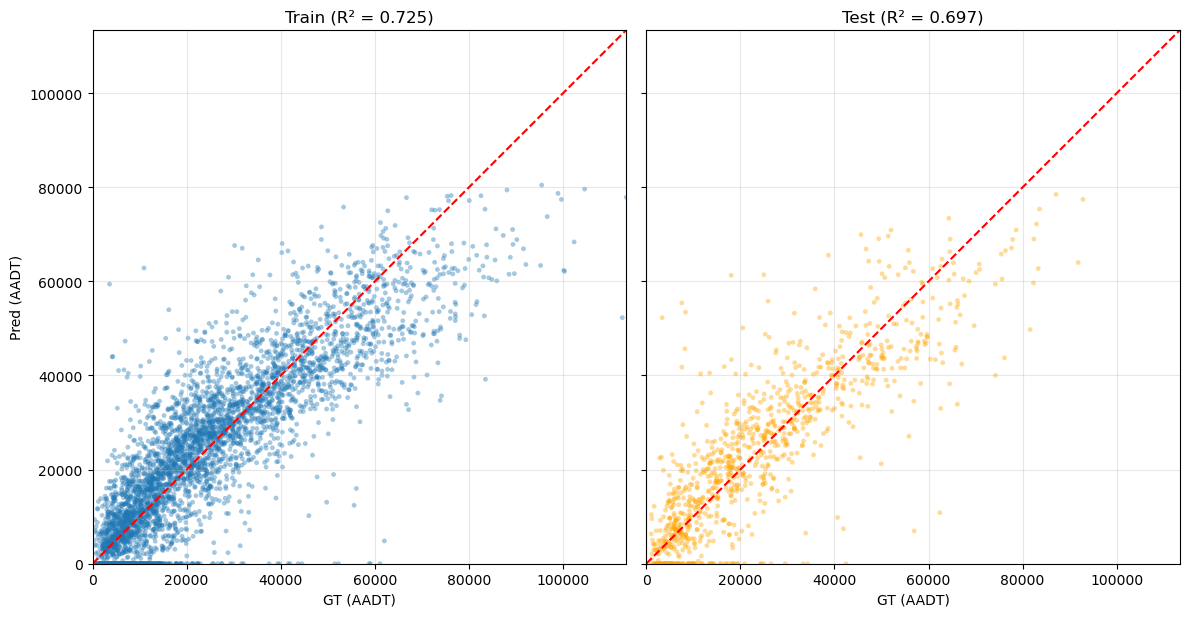

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from model.utils import R_square  # your R²

def scatter_plot_pair(gt_train, pred_train, gt_test, pred_test):
    
    # Convert to tensors for R² calculation
    gt_train_t = torch.tensor(gt_train).float().view(-1,1)
    pred_train_t = torch.tensor(pred_train).float().view(-1,1)
    gt_test_t = torch.tensor(gt_test).float().view(-1,1)
    pred_test_t = torch.tensor(pred_test).float().view(-1,1)

    r2_train = R_square(gt_train_t, pred_train_t, scaler=None).item()
    r2_test  = R_square(gt_test_t,  pred_test_t,  scaler=None).item()

    # Shared axis limits based on all values
    low = min(gt_train.min(), pred_train.min(), gt_test.min(), pred_test.min())
    high = max(gt_train.max(), pred_train.max(), gt_test.max(), pred_test.max())

    fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)

    # --- Train ---
    axs[0].scatter(gt_train, pred_train, s=12, alpha=0.4, edgecolor="none")
    axs[0].plot([low, high], [low, high], 'r--', linewidth=1.5)
    axs[0].set_title(f"Train (R² = {r2_train:.3f})")
    axs[0].set_xlabel("GT (AADT)")
    axs[0].set_ylabel("Pred (AADT)")
    axs[0].set_aspect('equal', 'box')
    axs[0].grid(alpha=0.3)

    # --- Test ---
    axs[1].scatter(gt_test, pred_test, s=12, alpha=0.4, edgecolor="none", color='orange')
    axs[1].plot([low, high], [low, high], 'r--', linewidth=1.5)
    axs[1].set_title(f"Test (R² = {r2_test:.3f})")
    axs[1].set_xlabel("GT (AADT)")
    axs[1].set_aspect('equal', 'box')
    axs[1].grid(alpha=0.3)

    for ax in axs:
        ax.set_xlim([low, high])
        ax.set_ylim([low, high])

    plt.tight_layout()
    plt.show()

# ---------- run ----------
scatter_plot_pair(gt_train, pred_train, gt_test, pred_test)

In [2]:
# Mean GEH / Mean MAE by highway (Train vs Test) — nonnegative metrics

import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------
# CONFIG
# -------------------------------
GEOJSON_PATH = "../data/highway_network/uk_driving_edges_simplified.geojson"
TRAIN_JSON   = "error_analysis/pred_results_train.json"
TEST_JSON    = "error_analysis/pred_results_test.json"
OUT_DIR      = Path("figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)

HIGHWAY_ORDER = [
    "motorway","motorway_link",
    "trunk","trunk_link",
    "primary","primary_link",
    "secondary","secondary_link",
    "tertiary","tertiary_link",
    "unclassified","residential","living_street","service"
]

# -------------------------------
# LOAD GEO EDGES
# -------------------------------
gdf = gpd.read_file(GEOJSON_PATH)

def build_edge_id(u, v, key):
    return f"{int(u)}_{int(v)}_{int(key)}"

gdf["edge_id"] = gdf.apply(lambda r: build_edge_id(r["u"], r["v"], r["key"]), axis=1)
gdf["highway"] = gdf["highway"].astype(str).str.lower()
gdf["highway"] = pd.Categorical(gdf["highway"], categories=HIGHWAY_ORDER, ordered=True)

# -------------------------------
# LOAD PRED RESULTS
# -------------------------------
def load_json_results(path, split):
    with open(path, "r") as f:
        rows = json.load(f)
    df = pd.DataFrame(rows)
    df["split"] = split
    df["gt"] = df["gt"].astype(float)
    df["pred"] = df["pred"].astype(float)
    return df

df = pd.concat(
    [load_json_results(TRAIN_JSON, "Train"),
     load_json_results(TEST_JSON,  "Test")],
    ignore_index=True
)

# -------------------------------
# MERGE, METRICS (nonnegative)
# -------------------------------
df = df.merge(gdf[["edge_id", "highway"]], on="edge_id", how="left").dropna(subset=["highway"])

eps = 1e-9
err = df["pred"] - df["gt"]
df["MAE"] = err.abs()
df["GEH"] = np.sqrt(2.0 * (err**2) / (np.maximum(df["pred"] + df["gt"], eps)))

# -------------------------------
# GROUP + ERRORBAR PLOT
# -------------------------------
def mean_ci95(x):
    x = pd.Series(x).dropna()
    if len(x) == 0:
        return np.nan, np.nan
    m = x.mean()
    ci = 1.96 * x.std(ddof=1) / np.sqrt(len(x)) if len(x) > 1 else 0.0
    return m, ci

def plot_metric(metric, ylabel):
    stats = []
    for (hwy, split), sub in df.groupby(["highway","split"], dropna=False):
        m, ci = mean_ci95(sub[metric])
        stats.append({"highway": hwy, "split": split, "mean": m, "ci": ci})
    stats = pd.DataFrame(stats)

    pivot = stats.pivot(index="highway", columns="split", values=["mean","ci"]).reindex(HIGHWAY_ORDER)
    pivot = pivot[~pivot.isna().all(axis=1)]

    mean_train = pivot["mean"]["Train"] if ("mean","Train") in pivot.columns else pd.Series(index=pivot.index, dtype=float)
    mean_test  = pivot["mean"]["Test"]  if ("mean","Test")  in pivot.columns else pd.Series(index=pivot.index, dtype=float)
    ci_train   = pivot["ci"]["Train"]   if ("ci","Train")   in pivot.columns else pd.Series(index=pivot.index, dtype=float)
    ci_test    = pivot["ci"]["Test"]    if ("ci","Test")    in pivot.columns else pd.Series(index=pivot.index, dtype=float)

    x = np.arange(len(pivot.index))
    width = 0.38

    plt.figure(figsize=(max(10, len(pivot.index)*0.6), 5))
    plt.bar(x - width/2, mean_train.values, yerr=ci_train.values, width=width, label="Train", alpha=0.9)
    plt.bar(x + width/2, mean_test.values,  yerr=ci_test.values,  width=width, label="Test",  alpha=0.9)

    plt.xticks(x, [str(i) for i in pivot.index], rotation=45, ha="right")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} by highway (mean ± 95% CI)")
    plt.grid(axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    out = OUT_DIR / f"{metric}_by_highway_train_vs_test.png"
    plt.savefig(out, dpi=160)
    plt.close()
    print(f"Saved: {out}")

# -------------------------------
# RUN
# -------------------------------
plot_metric("MAE", "Mean MAE")
plot_metric("GEH", "Mean GEH")

C:\Users\yueli\AppData\Local\Temp\ipykernel_23316\2645143299.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (hwy, split), sub in df.groupby(["highway","split"], dropna=False):


Saved: figures\MAE_by_highway_train_vs_test.png
Saved: figures\GEH_by_highway_train_vs_test.png


C:\Users\yueli\AppData\Local\Temp\ipykernel_23316\2645143299.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (hwy, split), sub in df.groupby(["highway","split"], dropna=False):


In [3]:
import json

# -------------------------------
# SAVE PLOT VALUES (reusable)
# -------------------------------
OUT_JSON = OUT_DIR / "metric_by_highway_train_vs_test_plot_values.json"

def compute_plot_values(metric):
    stats = []
    for (hwy, split), sub in df.groupby(["highway", "split"], dropna=False):
        m, ci = mean_ci95(sub[metric])
        if pd.isna(hwy) or pd.isna(split):
            continue
        stats.append({
            "highway": str(hwy),
            "split": str(split),
            "mean": None if pd.isna(m) else float(m),
            "ci95": None if pd.isna(ci) else float(ci),
            "n": int(sub[metric].dropna().shape[0]),
        })

    # Keep only highway categories you care about, in your specified order
    hwy_set = set([s["highway"] for s in stats])
    highways_in_data = [h for h in HIGHWAY_ORDER if h in hwy_set]

    # Build a pivot-like dict for easy plotting later
    out = {"highways": highways_in_data, "Train": {}, "Test": {}}
    for h in highways_in_data:
        out["Train"][h] = {"mean": None, "ci95": None, "n": 0}
        out["Test"][h]  = {"mean": None, "ci95": None, "n": 0}

    for s in stats:
        h = s["highway"]
        if h not in out["highways"]:
            continue
        split = s["split"]
        if split not in ("Train", "Test"):
            continue
        out[split][h] = {"mean": s["mean"], "ci95": s["ci95"], "n": s["n"]}

    return out

plot_values = {
    "highway_order": HIGHWAY_ORDER,
    "metrics": {
        "MAE": compute_plot_values("MAE"),
        "GEH": compute_plot_values("GEH"),
    },
    "notes": {
        "ci95_definition": "mean ± 1.96 * sd / sqrt(n) (sd uses ddof=1; if n<=1 then ci95=0)",
        "geh_definition": "sqrt(2*(pred-gt)^2/(pred+gt)) with eps guard on denom",
    }
}

with open(OUT_JSON, "w", encoding="utf-8") as f:
    json.dump(plot_values, f, indent=2)

print("Saved plot values JSON:", OUT_JSON)

Saved plot values JSON: figures\metric_by_highway_train_vs_test_plot_values.json


C:\Users\yueli\AppData\Local\Temp\ipykernel_23316\2302078763.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (hwy, split), sub in df.groupby(["highway", "split"], dropna=False):
C:\Users\yueli\AppData\Local\Temp\ipykernel_23316\2302078763.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (hwy, split), sub in df.groupby(["highway", "split"], dropna=False):


In [5]:
gdf["highway"] = gdf["highway"].astype(str).str.lower()

# Count
tbl = gdf["highway"].value_counts().reset_index()
tbl.columns = ["highway", "count"]

print(tbl)

          highway    count
0             nan  6560834
1         primary   259854
2       secondary   227438
3           trunk   146752
4      trunk_link    11882
5    primary_link     5031
6   motorway_link     3565
7        motorway     3464
8  secondary_link     1614


In [7]:
import json
import geopandas as gpd
import pandas as pd

# --- paths ---
GEOJSON_PATH = "highway_network/uk_driving_edges_simplified.geojson"
TRAIN_JSON   = "inference/pred_results_train.json"
TEST_JSON    = "inference/pred_results_test.json"

# --- Load GeoJSON of simplified network ---
# gdf = gpd.read_file(GEOJSON_PATH)
gdf["edge_id"] = (
    gdf["u"].astype(str) + "_" +
    gdf["v"].astype(str) + "_" +
    gdf["key"].astype(str)
)
gdf["highway"] = gdf["highway"].astype(str).str.lower()

# --- Load Train edges ---
with open(TRAIN_JSON, "r") as f:
    train_rows = json.load(f)
train_edge_ids = set(r["edge_id"] for r in train_rows)

# --- Load Test edges ---
with open(TEST_JSON, "r") as f:
    test_rows = json.load(f)
test_edge_ids = set(r["edge_id"] for r in test_rows)

# --- Filter GeoDataFrame ---
g_train = gdf[gdf["edge_id"].isin(train_edge_ids)]
g_test  = gdf[gdf["edge_id"].isin(test_edge_ids)]

# --- Count highway types ---
tbl_train = g_train["highway"].value_counts().rename("Train_Count")
tbl_test  = g_test["highway"].value_counts().rename("Test_Count")

# --- Combine into comparison table ---
tbl = pd.concat([tbl_train, tbl_test], axis=1).fillna(0).astype(int)
tbl.index.name = "highway"
tbl = tbl.reset_index()

print(tbl)

# Optional: Save table
tbl.to_csv("inference/highway_tag_counts_train_test.csv", index=False)
print("Saved: inference/highway_tag_counts_train_test.csv")

         highway  Train_Count  Test_Count
0       motorway         1343         357
1          trunk          898         239
2  motorway_link          818         178
3     trunk_link          223          45
4        primary            7           0
5      secondary            1           0
Saved: inference/highway_tag_counts_train_test.csv


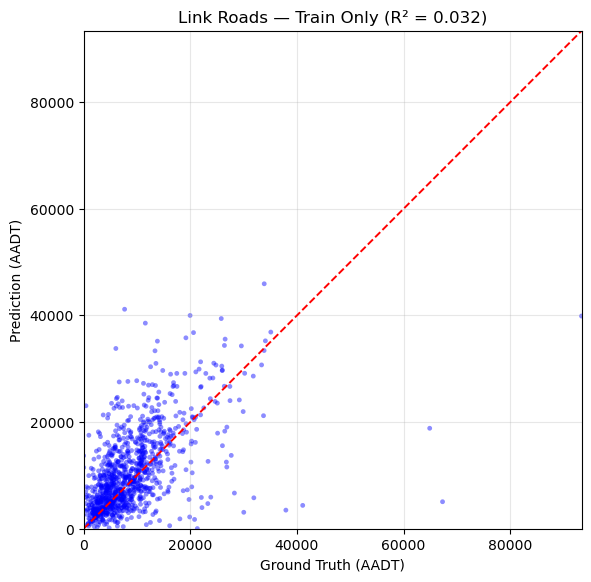

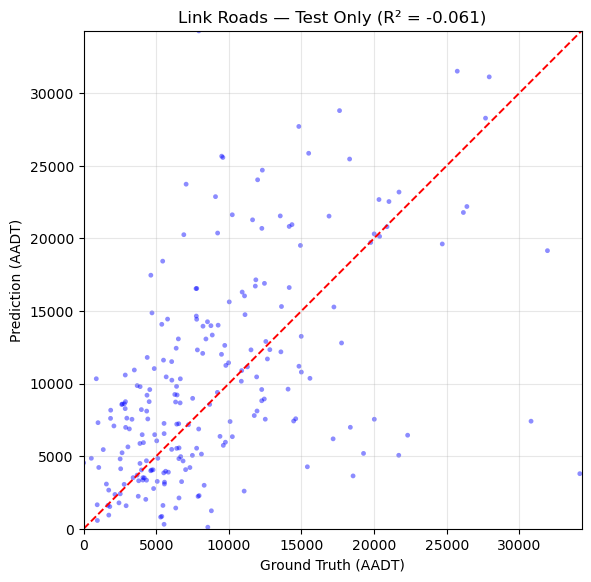

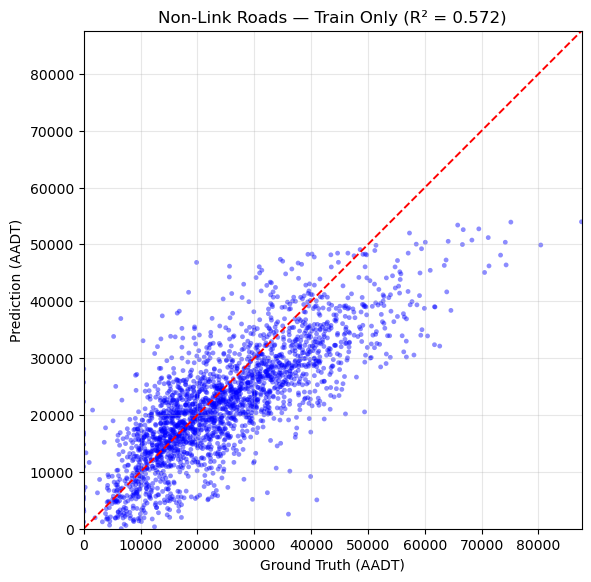

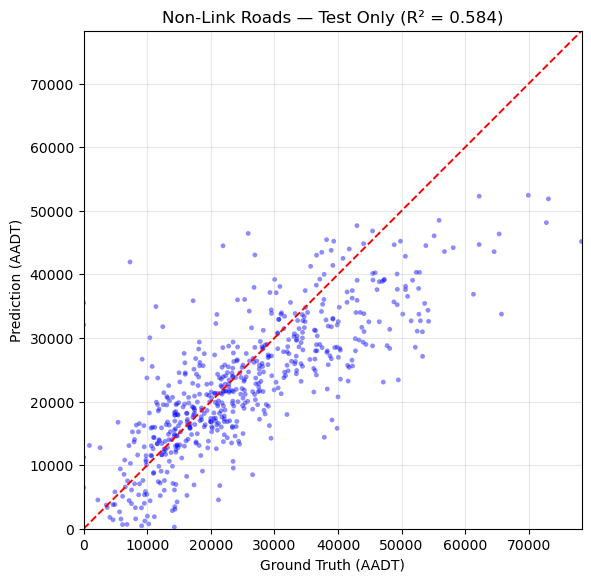

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from model.utils import R_square

TRAIN_JSON = "error_analysis/pred_results_train.json"
TEST_JSON  = "error_analysis/pred_results_test.json"

def load_pred_json(path):
    with open(path, "r") as f:
        data = json.load(f)
    edge_ids = np.array([x["edge_id"] for x in data])
    gt       = np.array([x["gt"]      for x in data], dtype=float)
    pred     = np.array([x["pred"]    for x in data], dtype=float)
    return edge_ids, gt, pred

edge_ids_train, gt_train, pred_train = load_pred_json(TRAIN_JSON)
edge_ids_test,  gt_test,  pred_test  = load_pred_json(TEST_JSON)
highway_map = gdf.set_index("edge_id")["highway"].astype(str).str.lower().to_dict()

import matplotlib.pyplot as plt
import torch
from model.utils import R_square

def scatter_single(name, gt_arr, pred_arr):
    # Convert to tensor for R²
    gt_t   = torch.tensor(gt_arr).float().view(-1,1)
    pred_t = torch.tensor(pred_arr).float().view(-1,1)
    r2_val = R_square(gt_t, pred_t, None).item()

    # shared scale
    low = min(gt_arr.min(), pred_arr.min())
    high = max(gt_arr.max(), pred_arr.max())

    plt.figure(figsize=(6,6))
    plt.scatter(gt_arr, pred_arr, s=12, alpha=0.45, color='blue', edgecolor='none')
    plt.plot([low, high], [low, high], 'r--', linewidth=1.4)
    plt.xlabel("Ground Truth (AADT)")
    plt.ylabel("Prediction (AADT)")
    plt.title(f"{name} (R² = {r2_val:.3f})")
    plt.xlim([low, high])
    plt.ylim([low, high])
    plt.gca().set_aspect('equal', 'box')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# --- Link roads ---
scatter_single("Link Roads — Train Only",
               gt_train[mask_train_link], pred_train[mask_train_link])

scatter_single("Link Roads — Test Only",
               gt_test[mask_test_link], pred_test[mask_test_link])

# --- Non-link roads ---
scatter_single("Non-Link Roads — Train Only",
               gt_train[mask_train_nonlink], pred_train[mask_train_nonlink])

scatter_single("Non-Link Roads — Test Only",
               gt_test[mask_test_nonlink], pred_test[mask_test_nonlink])

In [21]:
#!/usr/bin/env python3
# ============================================================
# Bar plots of error vs meta bins (Train vs Test):
#   1) MAE by number of valid years (1..8)
#   2) GEH by number of valid years (1..8)
#   3) MAE by number of sensors per edge (1..11, 12+)
#   4) GEH by number of sensors per edge (1..11, 12+)
#
# Inputs:
#   - error_analysis/pred_results_train.json
#   - error_analysis/pred_results_test.json
#   - ../data/traffic_volume/GT_AADT_8years_meta.json
#
# Notes:
#   - "number of valid years" = len(years_used) from meta
#   - "number of sensors per edge" = max(n_sensors_per_year.values()) from meta,
#       binned as 1..11 and "12+"
#   - MAE = |pred - gt|
#   - GEH = sqrt( 2*(pred-gt)^2 / (pred+gt+eps) )
#   - Train=blue, Test=red (your fixed palette)
# ============================================================

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
TRAIN_JSON = "error_analysis/pred_results_train.json"
TEST_JSON  = "error_analysis/pred_results_test.json"
META_JSON  = "../data/traffic_volume/GT_AADT_8years_meta.json"

OUT_DIR = Path("error_analysis")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Train = blue, Test = red (same as before)
COLOR_TRAIN = (31/255, 119/255, 180/255)
COLOR_TEST  = (214/255, 39/255, 40/255)

# ---------- LOADERS ----------
def load_pred_json(path: str) -> pd.DataFrame:
    with open(path, "r", encoding="utf-8") as f:
        rows = json.load(f)
    df = pd.DataFrame([{
        "edge_id": str(r["edge_id"]),
        "gt_pred": float(r["gt"]),
        "pred": float(r["pred"]),
    } for r in rows])

    # If duplicates exist: average (conservative, avoids double-counting)
    df = df.groupby("edge_id", as_index=False).mean(numeric_only=True)
    return df

def load_meta_json(path: str) -> pd.DataFrame:
    with open(path, "r", encoding="utf-8") as f:
        meta = json.load(f)

    out = []
    for eid, rec in meta.items():
        years_used = rec.get("years_used", [])
        n_years = int(len(years_used))

        n_sensors_per_year = rec.get("n_sensors_per_year", {}) or {}
        if isinstance(n_sensors_per_year, dict) and len(n_sensors_per_year) > 0:
            try:
                n_sensors = int(max(int(v) for v in n_sensors_per_year.values()))
            except Exception:
                n_sensors = np.nan
        else:
            n_sensors = np.nan

        out.append({
            "edge_id": str(eid),
            "n_years": n_years,
            "n_sensors": n_sensors,
        })

    dfm = pd.DataFrame(out)
    return dfm

# ---------- METRICS ----------
def add_error_metrics(df: pd.DataFrame) -> pd.DataFrame:
    # expects columns: gt_pred, pred
    gt = df["gt_pred"].to_numpy(dtype=float)
    pr = df["pred"].to_numpy(dtype=float)
    err = pr - gt
    mae = np.abs(err)
    geh = np.sqrt(2.0 * (err ** 2) / (pr + gt + 1e-9))
    out = df.copy()
    out["MAE"] = mae
    out["GEH"] = geh
    return out

# ---------- BINNING ----------
def sensors_bin_label(n):
    if not np.isfinite(n):
        return None
    n = int(n)
    return "12+" if n >= 12 else str(n)  # "1".."11" or "12+"

def prepare_group_stats(df_joined: pd.DataFrame, group_col: str, metric: str, order: list[str]) -> pd.Series:
    """
    Returns mean(metric) per group in the provided order.
    Missing groups -> NaN
    """
    g = df_joined.groupby(group_col)[metric].mean()
    return pd.Series([g.get(k, np.nan) for k in order], index=order)

def plot_train_test_bars(x_labels, y_train, y_test, ylabel, title, out_pdf, ylim_adjust=1.2):
    x = np.arange(len(x_labels))
    w = 0.38

    plt.figure(figsize=(5, 3))
    plt.bar(x - w/2, y_train, width=w, color=COLOR_TRAIN, label="Train")
    plt.bar(x + w/2, y_test,  width=w, color=COLOR_TEST,  label="Test")
    ymax = np.nanmax(np.concatenate([y_train, y_test]))
    plt.ylim(0, ymax * ylim_adjust)
    plt.xticks(x, x_labels, rotation=0)
    plt.xlabel(title.split(" by ")[-1])  # uses the part after "by" for a clean x label
    plt.ylabel(ylabel)
    plt.title(title)
    # plt.legend()
    plt.tight_layout()
    plt.savefig(out_pdf)
    plt.close()
    print(f"Saved: {out_pdf}")

# ========================= RUN =========================
df_meta = load_meta_json(META_JSON)

df_tr = add_error_metrics(load_pred_json(TRAIN_JSON))
df_te = add_error_metrics(load_pred_json(TEST_JSON))

# Join meta
df_trj = df_tr.merge(df_meta, on="edge_id", how="left")
df_tej = df_te.merge(df_meta, on="edge_id", how="left")

# ---- X1: number of valid years (1..8) ----
years_order = [str(i) for i in range(1, 9)]
df_trj["n_years_lbl"] = df_trj["n_years"].astype("Int64").astype(str)
df_tej["n_years_lbl"] = df_tej["n_years"].astype("Int64").astype(str)

mae_tr_year = prepare_group_stats(df_trj, "n_years_lbl", "MAE", years_order).to_numpy(dtype=float)
mae_te_year = prepare_group_stats(df_tej, "n_years_lbl", "MAE", years_order).to_numpy(dtype=float)
geh_tr_year = prepare_group_stats(df_trj, "n_years_lbl", "GEH", years_order).to_numpy(dtype=float)
geh_te_year = prepare_group_stats(df_tej, "n_years_lbl", "GEH", years_order).to_numpy(dtype=float)

plot_train_test_bars(
    x_labels=years_order,
    y_train=mae_tr_year,
    y_test=mae_te_year,
    ylabel="MAE",
    title="MAE by number of valid years",
    out_pdf=OUT_DIR / "bar_mae_by_valid_years_train_vs_test.svg",
    ylim_adjust=1.5
)
plot_train_test_bars(
    x_labels=years_order,
    y_train=geh_tr_year,
    y_test=geh_te_year,
    ylabel="MGEH",
    title="MGEH by number of valid years",
    out_pdf=OUT_DIR / "bar_geh_by_valid_years_train_vs_test.svg",
    ylim_adjust=1.5
)

# ---- X2: number of sensors per edge (1..11, 12+) ----
sensor_order = [str(i) for i in range(1, 12)] + ["12+"]

df_trj["n_sensors_lbl"] = df_trj["n_sensors"].apply(sensors_bin_label)
df_tej["n_sensors_lbl"] = df_tej["n_sensors"].apply(sensors_bin_label)

mae_tr_sen = prepare_group_stats(df_trj, "n_sensors_lbl", "MAE", sensor_order).to_numpy(dtype=float)
mae_te_sen = prepare_group_stats(df_tej, "n_sensors_lbl", "MAE", sensor_order).to_numpy(dtype=float)
geh_tr_sen = prepare_group_stats(df_trj, "n_sensors_lbl", "GEH", sensor_order).to_numpy(dtype=float)
geh_te_sen = prepare_group_stats(df_tej, "n_sensors_lbl", "GEH", sensor_order).to_numpy(dtype=float)

plot_train_test_bars(
    x_labels=sensor_order,
    y_train=mae_tr_sen,
    y_test=mae_te_sen,
    ylabel="MAE",
    title="MAE by number of sensors per edge",
    out_pdf=OUT_DIR / "bar_mae_by_sensors_train_vs_test.svg",
    ylim_adjust=1.2
)
plot_train_test_bars(
    x_labels=sensor_order,
    y_train=geh_tr_sen,
    y_test=geh_te_sen,
    ylabel="MGEH",
    title="MGEH by number of sensors per edge",
    out_pdf=OUT_DIR / "bar_geh_by_sensors_train_vs_test.svg",
    ylim_adjust=1.2
)

Saved: error_analysis\bar_mae_by_valid_years_train_vs_test.svg
Saved: error_analysis\bar_geh_by_valid_years_train_vs_test.svg
Saved: error_analysis\bar_mae_by_sensors_train_vs_test.svg
Saved: error_analysis\bar_geh_by_sensors_train_vs_test.svg


In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

# --- Load number of sensors ---
with open("../data/traffic_volume/edge_to_sensor.json", "r") as f:
    edge_to_sensor = json.load(f)

def get_sensor_counts(edge_ids):
    return np.array([len(edge_to_sensor.get(eid, [])) for eid in edge_ids])

sensor_train = get_sensor_counts(edge_ids_train)
sensor_test  = get_sensor_counts(edge_ids_test)

# --- Define bins ---
def bin_sensors(n):
    if n == 1: return "1"
    if n == 2: return "2"
    if n == 3: return "3"
    if 4 <= n <= 5: return "4–5"
    if 6 <= n <= 10: return "6–10"
    return "10+"

bins_train = np.array([bin_sensors(n) for n in sensor_train])
bins_test  = np.array([bin_sensors(n) for n in sensor_test])

bin_categories = ["1","2","3","4–5","6–10","10+"]

# --- Compute errors ---
mae_train = np.abs(pred_train - gt_train)
mae_test  = np.abs(pred_test  - gt_test)

geh_train = np.sqrt(2 * (pred_train - gt_train)**2 / (pred_train + gt_train + 1e-9))
geh_test  = np.sqrt(2 * (pred_test  - gt_test )**2 / (pred_test  + gt_test  + 1e-9))

def compute_mean_sd(err, labels, categories):
    means = []
    sds = []
    ns = []
    for c in categories:
        vals = err[labels == c]
        means.append(np.mean(vals) if len(vals) else np.nan)
        sds.append(np.std(vals)  if len(vals) else np.nan)
        ns.append(len(vals))
    return np.array(means), np.array(sds), np.array(ns)

mae_mean_tr, mae_sd_tr, _ = compute_mean_sd(mae_train, bins_train, bin_categories)
mae_mean_te, mae_sd_te, _ = compute_mean_sd(mae_test,  bins_test,  bin_categories)

geh_mean_tr, geh_sd_tr, _ = compute_mean_sd(geh_train, bins_train, bin_categories)
geh_mean_te, geh_sd_te, _ = compute_mean_sd(geh_test,  bins_test,  bin_categories)

# --- Plot function ---
def plot_error_bar(means_tr, sds_tr, means_te, sds_te, ylabel, title):
    x = np.arange(len(bin_categories))
    width = 0.35

    plt.figure(figsize=(8,4))
    plt.bar(x - width/2, means_tr, width, yerr=sds_tr, capsize=4, 
            label="Train", color="blue", alpha=0.75)
    plt.bar(x + width/2, means_te, width, yerr=sds_te, capsize=4, 
            label="Test", color="orange", alpha=0.75)

    plt.xticks(x, bin_categories)
    plt.ylabel(ylabel)
    plt.xlabel("# of Sensors Attached to Edge")
    plt.title(title)
    plt.grid(axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Final plots ---
plot_error_bar(mae_mean_tr, mae_sd_tr, mae_mean_te, mae_sd_te,
               ylabel="MAE (|pred - gt|)",
               title="MAE vs Number of Sensors per Edge")

plot_error_bar(geh_mean_tr, geh_sd_tr, geh_mean_te, geh_sd_te,
               ylabel="GEH",
               title="GEH vs Number of Sensors per Edge")

NameError: name 'edge_ids_train' is not defined